<a href="https://colab.research.google.com/github/guga06436/digital-image-processing-app/blob/main/digital_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖼️🔬 [**Digital Image Processing**](https://github.com/guga06436/digital-image-processing-app)

## [Step 1] ⚙️ Install the required libraries

Click ▶️ button below to install the dependencies for this notebook.

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }
from typing import Callable
from abc import ABC, abstractmethod

from PIL import Image
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

## [Step 2] 📁 Upload your image and kernel files to the Files folder

⬅️ Files folder in Google Colab is on the left menu

## [Step 3] 🔍 Define Image Processing Classes

Click ▶️ button below to declare all classes for this notebook.

### Filters

#### Abstract Class

In [ ]:
class Filter(ABC):
    """
    Abstract base class for image filters.
    """

    @abstractmethod
    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Applies a filter to the image.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        pass

#### Pontual Filters

In [ ]:
class LinearFilter(Filter):
    """
    Applies linear filters to pixel intensity values.
    This class serves as a template for different linear filters.
    """

    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Method to be overridden by specific filters that apply a transformation to an image.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        pass

In [ ]:
class TriangularFilter(LinearFilter):
    """
    Triangular filter for pixel intensity values.
    """

    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Applies a triangular filter to the entire image using NumPy.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The filtered image with integer pixel values.
        """
        result = np.zeros_like(image)
        condition1 = (0 <= image) & (image <= 128)
        condition2 = (128 < image) & (image <= 255)

        result[condition1] = np.floor((255 / 128) * image[condition1])
        result[condition2] = np.floor(255 - (255 / 127) * (image[condition2] - 128))

        return result.astype(int)

In [ ]:
class BinarizationFilter(LinearFilter):
    """
    Binarization filter for pixel intensity values.
    """

    def __init__(self, threshold: int):
        """
        Initializes the binarization filter with a threshold value.

        Parameters:
        -----------
        threshold : int
            The threshold value for binarization.
        """
        self.threshold = threshold

    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Applies a binarization filter to the pixel intensity values based on a threshold.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The binarized image.
        """
        result = np.zeros_like(image)
        condition = image >= self.threshold
        result[condition] = 255

        return result.astype(int)

#### Correlation Filters

In [ ]:
class CorrelationFilter(Filter):
    """
    Base class for applying correlation filters to pixel intensity values.
    This class serves as a template for specific correlation filters.

    Attributes:
    -----------
    offset : int
        An integer value used to adjust the brightness of the image after applying the filter.
    """

    def __init__(self, offset: int):
        self.offset = offset

    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Method to be overridden by specific filters that apply a transformation to an image.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        pass

    def _apply_offset(self, image: np.ndarray):
        """
        Applies a brightness offset to the image by adding the offset value.

        Parameters:
        -----------
        image : np.ndarray
            The image to be processed.

        Returns:
        --------
        np.ndarray
            The image with brightness adjusted.
        """
        image = image + self.offset
        # Apply the offset by adding the offset value to the image pixel values
        # Clip the values to stay within the valid range for pixel values (0-255 for 8-bit images)
        image = np.clip(image, 0, 255).astype(np.uint8)
        return image

    def _correlation(self, image: np.ndarray) -> np.ndarray:
        """
        Applies the correlation filter to the image.

        The method pads the image with zeros to account for the filter's size, then applies the
        mask using a sliding window approach. The mask is shifted
        by the defined offset before being applied to each window of the image.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        # Ensure the image is of float type to prevent issues during computation
        image = image.astype(np.float64)

        # Get the mask dimensions
        mask_height, mask_width = self.mask.shape

        # Compute padding amounts for height
        if mask_height % 2 == 0:
            # Even-sized mask
            pad_top = mask_height // 2
            pad_bottom = mask_height // 2 - 1
        else:
            # Odd-sized mask
            pad_top = pad_bottom = mask_height // 2

        # Compute padding amounts for width
        if mask_width % 2 == 0:
            # Even-sized mask
            pad_left = mask_width // 2
            pad_right = mask_width // 2 - 1
        else:
            # Odd-sized mask
            pad_left = pad_right = mask_width // 2

        # Pad the image with zeros to maintain original image size after filtering
        padded_image = np.pad(
            image,
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode='constant',
            constant_values=0
        )

        # Get the dimensions of the original image
        image_height, image_width = image.shape

        # Create an empty array for the output image
        filtered_image = np.zeros((image_height, image_width), dtype=np.float64)

        # Apply the mask using nested loops
        for i in range(image_height):
            for j in range(image_width):
                # Extract the current window
                current_window = padded_image[i:i + mask_height, j:j + mask_width]

                # Apply the mask (element-wise multiplication and summing)
                filtered_value = np.sum(current_window * self.mask)

                # Assign the result to the corresponding pixel in the filtered image
                filtered_image[i, j] = filtered_value

        return filtered_image

In [ ]:
class SmoothingFilter(CorrelationFilter):
    """
    Smoothing filter for pixel intensity values.

    This class applies a Smoothing filter to smooth pixel intensities in an image given a mask.
    The filter reduces noise by averaging surrounding pixel intensities weighted by the mask.

    Attributes:
    -----------
    mask : np.ndarray
        A 2D array representing the mask applied during correlation.
    offset : int
        An integer value used to adjust the brightness of the image after applying the filter.

    Methods:
    --------
    apply(image: np.ndarray) -> np.ndarray
        Applies the Gaussian filter to a given image.
    """
    def __init__(self, offset: int, mask: np.ndarray):
        self.mask = mask
        self.offset = offset


    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Applies the smoothing filter to a given image by convolving it with a mask.

        The method pads the image with zeros to account for the filter's size, then applies the
        filter using a sliding window approach. It correctly handles both even and odd-sized masks.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        filtered_image = self._correlation(image)

        # Clip the values to the valid range and convert to uint8
        filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)

        # apply offset to image
        filtered_image = self._apply_offset(filtered_image)

        return filtered_image

In [ ]:
class BorderDetectionFilter(CorrelationFilter):
    """
    Border Detection filter for edge detection in images.

    The Border Detection filter is used to highlight edges by calculating the gradient of pixel intensity values
    in both horizontal and vertical directions. It is commonly used in edge detection algorithms to
    identify regions of rapid intensity change (edges) in an image.

    Attributes:
    -----------
    mask : np.ndarray
        A 2D array representing the mask applied during correlation.
    offset : int
        An integer value used to adjust the brightness of the image after applying the filter.

    Methods:
    --------
    apply(image: np.ndarray) -> np.ndarray
        Applies the Border Detection filter to a given image to detect edges.
    """
    def __init__(self, offset: int, mask: np.ndarray):
        self.mask = mask
        self.offset = offset

    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Applies the Border Detection filter to the image.

        The method pads the image with zeros to account for the Sobel filter's size, then applies the
        mask using a sliding window approach. The masks are shifted
        by the defined offset before being applied to each window of the image.

        Parameters:
        -----------
        image : np.ndarray
            A 2D array representing the grayscale image to be filtered.

        Returns:
        --------
        np.ndarray
            A 2D array representing the filtered image, where each pixel value represents the magnitude
            of the intensity gradient (edge strength).
        """
        # Perform the correlation
        gradient = self._correlation(image)

        gradient = np.abs(gradient)

        gradient = Histogram().expand(gradient)

        # apply offset to image
        gradient = self._apply_offset(gradient)

        return gradient.astype(int)

In [ ]:
class SobelFilter(CorrelationFilter):
    """
    Sobel filter for edge detection in images.

    The Sobel filter detects edges by calculating the gradient of pixel intensity values
    in both horizontal and vertical directions, using Sobel masks.

    Methods:
    --------
    apply(image: np.ndarray) -> np.ndarray
        Applies the Sobel filter to a given image to detect edges and expands the histogram for better contrast.
    """

    def __init__(self, offset: int):
        """
        Initializes the Sobel filter with predefined horizontal and vertical Sobel masks.

        Parameters:
        -----------
        offset : int
            An integer value used to adjust the brightness of the image after applying the filter.
        """
        super().__init__(offset=offset)
        # Sobel X mask to detect vertical edges
        self.sobel_x = np.array([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ])

        # Sobel Y mask to detect horizontal edges
        self.sobel_y = np.array([
            [-1, -2, -1],
            [ 0,  0,  0],
            [ 1,  2,  1]
        ])

    def apply(self, image: np.ndarray) -> np.ndarray:
        """
        Applies the Sobel filter to the image to detect edges.

        The method calculates both the horizontal and vertical gradients using Sobel filters, computes
        the gradient magnitude, and expands the histogram of the result.

        Parameters:
        -----------
        image : np.ndarray
            A 2D array representing the grayscale image to be filtered.

        Returns:
        --------
        np.ndarray
            A 2D array representing the filtered image with expanded contrast.
        """
        # Apply Sobel X filter
        self.mask = self.sobel_x
        gradient_x = self._correlation(image)

        # Apply Sobel Y filter
        self.mask = self.sobel_y
        gradient_y = self._correlation(image)

        # Compute the gradient magnitude
        gradient = np.abs(gradient_x) + np.abs(gradient_y)

        # Expand the histogram to enhance contrast
        gradient = Histogram().expand(gradient)

        # apply offset to image
        gradient = self._apply_offset(gradient)

        # Convert to uint8
        gradient = gradient.astype(np.uint8)

        return gradient

    def _apply_mask(self, image: np.ndarray, mask: np.ndarray) -> np.ndarray:
        """
        Applies the given mask (Sobel X or Sobel Y) to the image.

        Parameters:
        -----------
        image : np.ndarray
            The grayscale image to which the mask will be applied.
        mask : np.ndarray
            The Sobel mask (3x3) used for edge detection.

        Returns:
        --------
        np.ndarray
            The filtered image showing the gradient in one direction.
        """
        # Get half of the mask width and height
        mask_half_width = mask.shape[0] // 2
        mask_half_height = mask.shape[1] // 2

        # Pad the image with zeros to maintain the original size after filtering
        padded_image = np.pad(image, ((mask_half_width, mask_half_width),
                                      (mask_half_height, mask_half_height)),
                              mode='constant', constant_values=0)

        # Create sliding window views over the padded image with the same size as the mask
        windows = sliding_window_view(padded_image, mask.shape)

        # Apply the mask by element-wise multiplication and summing over the window
        filtered_image = np.sum(windows * mask, axis=(-2, -1))

        return filtered_image

#### Histogram Executor

In [ ]:
class Histogram:
    """
    A class to perform histogram operations on images, including histogram expansion.

    Histogram expansion adjusts the contrast of an image by expanding the intensity
    values of the image to cover the full possible intensity range (e.g., 0 to 255).

    Methods:
    --------
    expand(image: np.ndarray) -> np.ndarray:
        Expands the histogram of the image to improve contrast.
    """

    @staticmethod
    def expand(image: np.ndarray) -> np.ndarray:
        """
        Expands the histogram of the image by adjusting the intensity values to the range [0, 255].

        Parameters:
        -----------
        image : np.ndarray
            A 2D or 3D array representing the image (grayscale or RGB) to be processed.

        Returns:
        --------
        np.ndarray
            The image with the expanded histogram, where the intensity values have been adjusted
            to the range [0, 255].
        """

        # Check if the image is RGB (3D) or grayscale (2D)
        if len(image.shape) == 3:  # RGB
            return np.stack([Histogram.expand_channel(image[:, :, i]) for i in range(3)], axis=-1)
        elif len(image.shape) == 2:  # Grayscale
            return Histogram.expand_channel(image)
        else:
            raise ValueError("Image must be 2D (grayscale) or 3D (RGB).")

    @staticmethod
    def expand_channel(channel: np.ndarray) -> np.ndarray:
        """
        Expands the histogram of a single channel (grayscale or one RGB channel).

        Parameters:
        -----------
        channel : np.ndarray
            A 2D array representing the image (grayscale or one of the RGB channels).

        Returns:
        --------
        np.ndarray
            The channel with the expanded histogram to the range [0, 255].
        """

        # Compute the minimum and maximum values in the channel
        min_val = np.min(channel)
        max_val = np.max(channel)

        # If the image already has full contrast, return it as-is
        if max_val == min_val:
            return channel  # Avoid division by zero

        # Expand the histogram
        expanded_channel = ((channel - min_val) / (max_val - min_val)) * 255

        # Convert to integer values and clip to the range [0, 255]
        return np.clip(expanded_channel, 0, 255).astype(np.uint8)

### Processor

In [ ]:
class ImageProcessor:
    """
    The ImageProcessor class contains methods for processing images using various filters.
    It applies filters to images by iterating over each pixel and applying the specified filter class.
    Supports both RGB and YIQ color spaces.

    Methods:
    --------
    apply_filter_rgb(image: np.ndarray, filter: Filter) -> np.ndarray
        Applies a specified linear filter to an RGB image.

    apply_filter_yiq(image: np.ndarray, filter: Filter) -> np.ndarray
        Applies a specified filter to the Y channel of an image in the YIQ color space, and then converts it back to RGB.
    """

    def _apply_filter_to_rgb_channels(self, image: np.ndarray, filter: Filter) -> np.ndarray:
        """
        Private method to apply a filter to each channel of an image.

        Parameters:
        -----------
        image : np.ndarray
            The image array to be filtered.

        filter : Filter
            The filter to be applied to each channel of the image.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        filtered_image = image.copy()
        for k in range(3):  # Iterate over RGB channels
            filtered_image[:, :, k] = filter.apply(image[:, :, k])
        return filtered_image

    def apply_filter_rgb(self, image: np.ndarray, filter: Filter) -> np.ndarray:
        """
        Applies a specified linear filter to an RGB image.

        Parameters:
        -----------
        image : np.ndarray
            The RGB image to be processed.

        filter : Filter
            The filter to be applied to each pixel channel.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        return self._apply_filter_to_rgb_channels(image, filter)

    def apply_filter_gray(self, image: np.ndarray, filter: Filter) -> np.ndarray:
        """
        Applies a specified linear filter to only one chanel.

        Parameters:
        -----------
        image : np.ndarray
            The RGB image to be processed.

        filter : Filter
            The filter to be applied to each pixel channel.

        Returns:
        --------
        np.ndarray
            The filtered image.
        """
        return filter.apply(image[:, :])

    def apply_filter_yiq(self, image: np.ndarray, filter: Filter) -> np.ndarray:
        """
        Applies a specified filter to the Y channel of an image in YIQ color space,
        then converts the result back to RGB.

        Parameters:
        -----------
        image : np.ndarray
            The RGB image to be processed.

        filter : Filter
            The filter to be applied to the Y channel.

        Returns:
        --------
        np.ndarray
            The processed image in RGB format.
        """

        # Convert RGB to YIQ
        Y = image[:, :, 0] * 0.299 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.114
        I = image[:, :, 0] * 0.5959 - image[:, :, 1] * 0.2746 - image[:, :, 2] * 0.3213
        Q = image[:, :, 0] * 0.2115 - image[:, :, 1] * 0.5227 + image[:, :, 2] * 0.3112

        # Apply filter to the Y channel
        Y_filtered = filter.apply(Y)

        # Convert back from YIQ to RGB
        R = Y_filtered + 0.956 * I + 0.619 * Q
        G = Y_filtered - 0.272 * I - 0.647 * Q
        B = Y_filtered - 1.106 * I + 1.703 * Q

        # Stack channels back into an RGB image
        rgb_image = np.stack((R, G, B), axis=-1)

        # Clip values to ensure they are in the 0-255 range and convert to uint8
        rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)

        return rgb_image

## [Step 3.5] Visualize Original Image

### Instructions:

1. **Set the image file path:**
   Edit the `image_file` parameter to match the path of your uploaded image file.

2. **Run the cell:**
   Execute the cell and wait for the image processing to complete.

### Notes:

- Make sure the specified image file exists in the '/content/' directory or provide the full path.

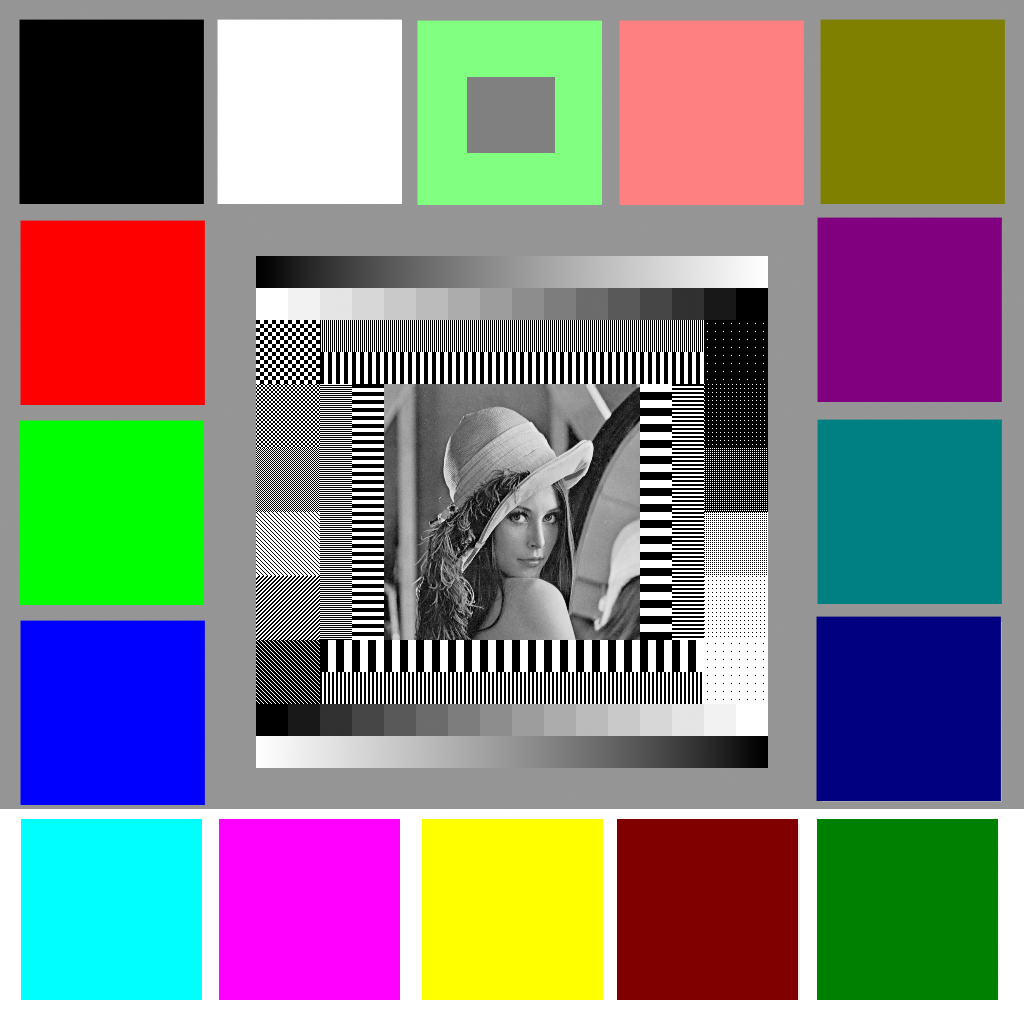

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }

image_file = 'images/lena.tif' # @param {type:"string"}

# Open the image file
image = Image.open(image_file)
display(image)

## [Step 4] • Pontual Filters •

### [Step 4.1] 🔺 Run Triangular Pontual Filter 🔺

### 🖼️ Image Processing with Triangular Filter

#### Instructions:

1. **Set the image file path:**
   Edit the `image_file` parameter to match the path of your uploaded image file.

2. **Choose the color space:**
   Select either "RGB" or "YIQ" for the `color_space` parameter.

3. **Run the cell:**
   Execute the cell and wait for the image processing to complete.

### Notes:

- The code currently applies the Triangular Filter regardless of the selected color space.
- The TriangularFilter is applied to all color channels of the image.
- Make sure the specified image file exists in the '/content/' directory or provide the full path.

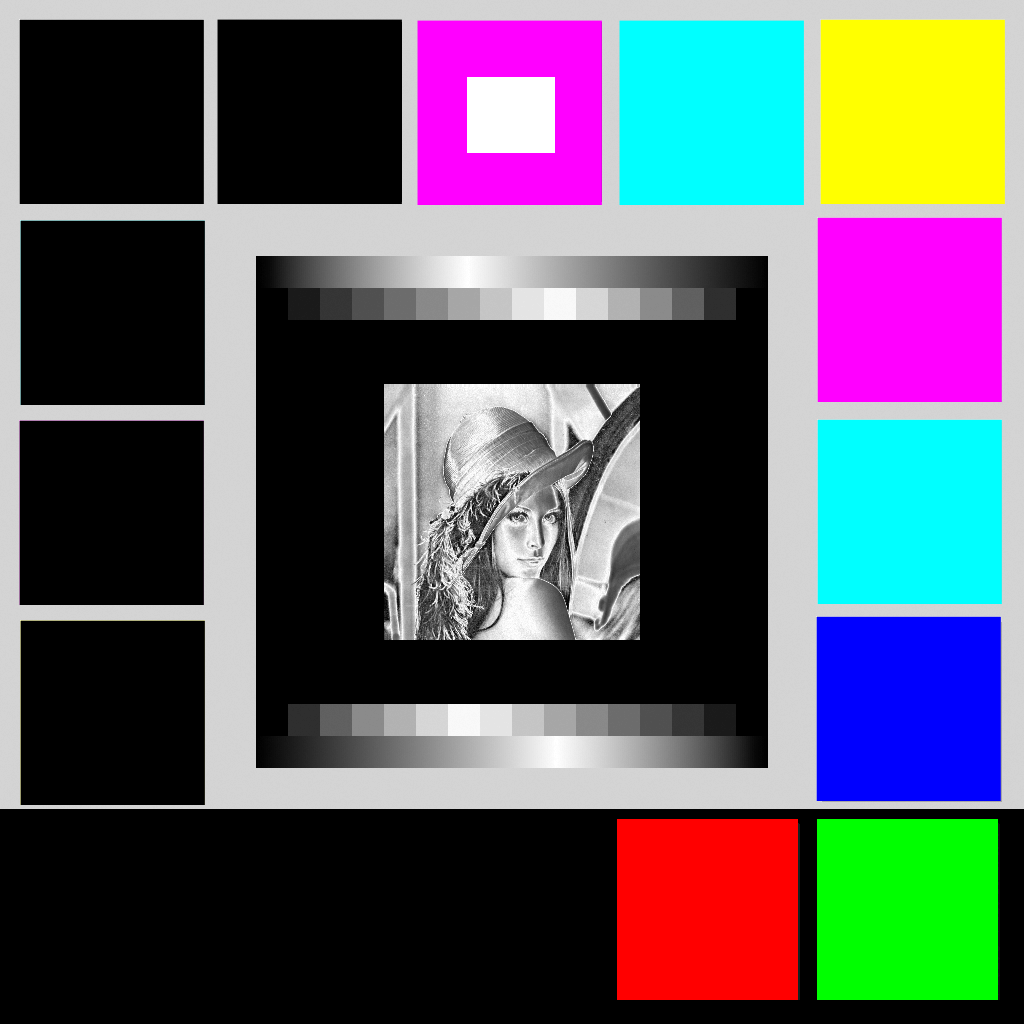

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }

image_file = 'images/lena.tif' # @param {type:"string"}
color_space = 'RGB'  # @param ["RGB", "YIQ"]

# Open the image file
image = Image.open(image_file)

# Convert the image to a numpy array
image_array = np.asarray(image, dtype=np.uint8)

# Apply linear filters
processor = ImageProcessor()
if color_space == 'RGB':
    image_output = processor.apply_filter_rgb(image_array, TriangularFilter())
else:
    image_output = processor.apply_filter_yiq(image_array, TriangularFilter())
display(Image.fromarray(image_output))

### [Step 4.2] ⚪⚫ Run Binarization Pontual Filter ⚫⚪

### 🖼️ Image Processing with Binarization Filter

#### Instructions:

1. **Set the image file path:**
   Edit the `image_file` parameter to match the path of your uploaded image file.

2. **Choose the color space:**
   Select either "RGB" or "YIQ" for the `color_space` parameter.

3. **Set the threshold value:**
   Adjust the `threshold` parameter to set the binarization threshold (0-255).

4. **Run the cell:**
   Execute the cell and wait for the image processing to complete.

### Notes:

- The Binarization Filter converts the image to black and white based on the threshold value.
- Pixels with intensity above the threshold become white (255), while those below become black (0).
- The filter is applied to all color channels if using RGB, or only to the Y channel if using YIQ.
- Make sure the specified image file exists in the '/content/' directory or provide the full path.

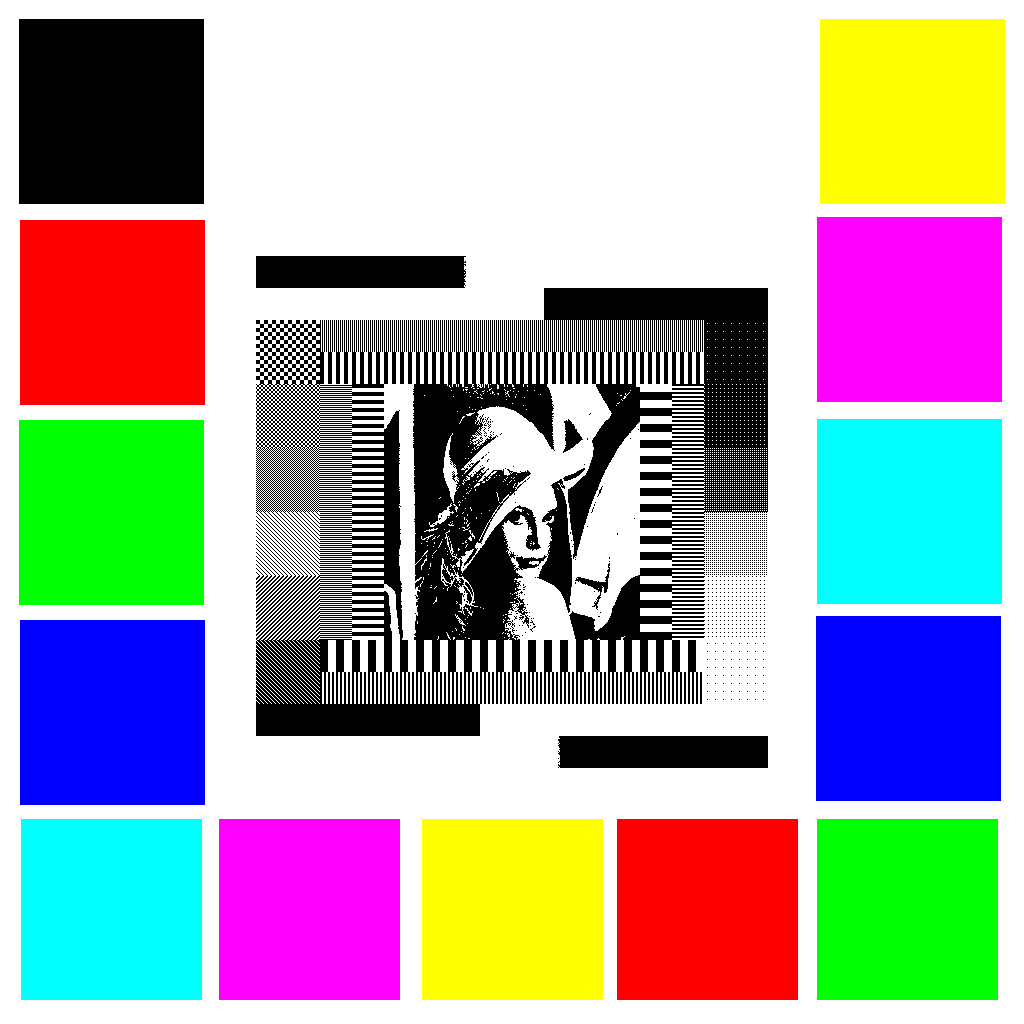

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }

image_file = 'images/lena.tif' # @param {type:"string"}
color_space = 'RGB'  # @param ["RGB", "YIQ"]
threshold = 127 # @param {type:"slider", min:0, max:255, step:1}

# Open the image file
image = Image.open(image_file)

# Convert the image to a numpy array
image_array = np.asarray(image, dtype=np.uint8)

# Apply linear filters
processor = ImageProcessor()
if color_space == 'RGB':
    image_output = processor.apply_filter_rgb(image_array, BinarizationFilter(threshold))
else:
    image_output = processor.apply_filter_yiq(image_array, BinarizationFilter(threshold))
display(Image.fromarray(image_output))

## [Step 5] 🔗 Correlation Filters 🔗

### [Step 5.1] 🌫️ Run Smoothing Correlation Filter 🌫️

### 🖼️ Image Processing with Smoothing Filter

#### Instructions:

1. **Set the image file path:**
   Edit the `image_file` parameter to match the path of your uploaded image file.

2. **Choose the color space:**
   Select either "RGB" or "YIQ" for the `color_space` parameter.

3. **Set the kernel/mask file path:**
   Edit the `kernel_file` parameter to match the path of your uploaded kernel txt file. The file should be formatted as follows:
   ```
   offset
   kernel_value kernel_value kernel_value ...
   kernel_value kernel_value kernel_value ...
   ...
   ```
   Example:
   ```
   0
   0.00296902 0.01330621 0.02193823 0.01330621 0.00296902
   0.01330621 0.0596343  0.09832033 0.0596343  0.01330621
   0.02193823 0.09832033 0.16210282 0.09832033 0.02193823
   0.01330621 0.0596343  0.09832033 0.0596343  0.01330621
   0.00296902 0.01330621 0.02193823 0.01330621 0.00296902
   ```
   The first line contains the offset, and the subsequent lines contain the kernel values.

4. **Run the cell:**
   Execute the cell and wait for the image processing to complete.

### Notes:

- The Smoothing Filter applies a correlation operation using the provided kernel to smooth the image.
- The filter reads the offset and kernel from the specified text file.
- The filter is applied to all color channels if using RGB, or only to the Y channel if using YIQ.
- Make sure both the image file and kernel file exist in the specified paths.

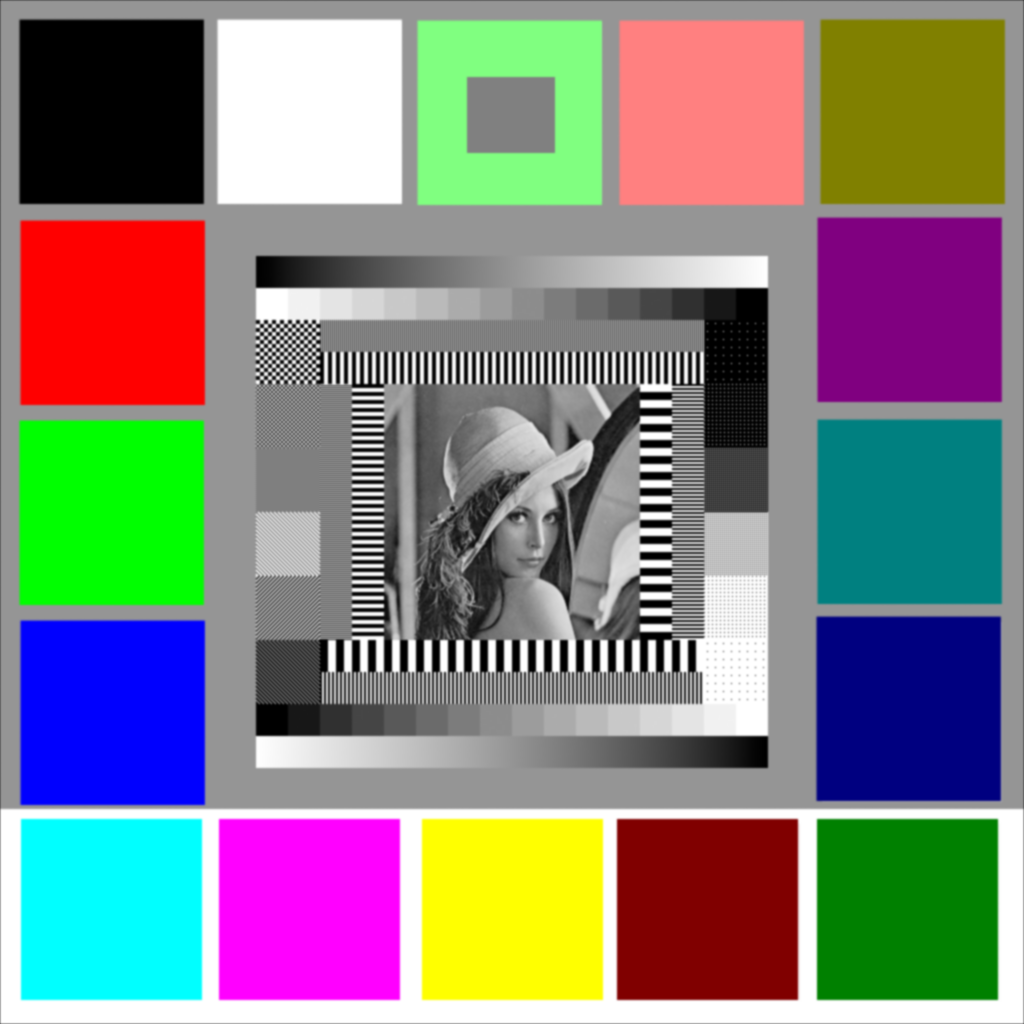

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }

image_file = 'images/lena.tif' # @param {type:"string"}
color_space = 'RGB'  # @param ["RGB", "YIQ"]
kernel_file = 'kernels/gaussian5x5.txt' # @param {type:"string"}

# Open the image file
image = Image.open(image_file)

with open(kernel_file, 'r') as file:
    # Read the offset from the first line
    offset = tuple(map(int, file.readline().strip().split()))

    # Read the rest of the lines as the kernel
    kernel_lines = file.readlines()
    kernel = np.array([list(map(float, line.strip().split())) for line in kernel_lines])

# Convert the image to a numpy array
image_array = np.asarray(image, dtype=np.uint8)

# Apply linear filters
processor = ImageProcessor()
if color_space == 'RGB':
    image_output = processor.apply_filter_rgb(image_array, SmoothingFilter(offset, kernel))
else:
    image_output = processor.apply_filter_yiq(image_array, SmoothingFilter(offset, kernel))
display(Image.fromarray(image_output))

### [Step 5.2] 🔲 Run Border Detection Filter 🔲

### 🖼️ Image Processing with Border Detection Filter

#### Instructions:

1. **Set the image file path:**
   Edit the `image_file` parameter to match the path of your uploaded image file.

2. **Choose the color space:**
   Select either "RGB" or "YIQ" for the `color_space` parameter.

3. **Set the kernel/mask file path:**
   Edit the `kernel_file` parameter to match the path of your uploaded kernel txt file. The file should be formatted as follows:
   ```
   offset
   kernel_value kernel_value kernel_value ...
   kernel_value kernel_value kernel_value ...
   ...
   ```
   Example:
   ```
   0
   -1 -1 -1
   -1  8 -1
   -1 -1 -1
   ```
   The first line contains the x and y offsets, and the subsequent lines contain the kernel values for edge detection.

4. **Run the cell:**
   Execute the cell and wait for the image processing to complete.

### Notes:

- The Border Detection Filter applies a correlation operation using the provided kernel to highlight edges in the image.
- The filter reads the offset and kernel from the specified text file.
- The filter is applied to all color channels if using RGB, or only to the Y channel if using YIQ.
- Make sure both the image file and kernel file exist in the specified paths.
- The resulting image will emphasize edges and boundaries in the original image.

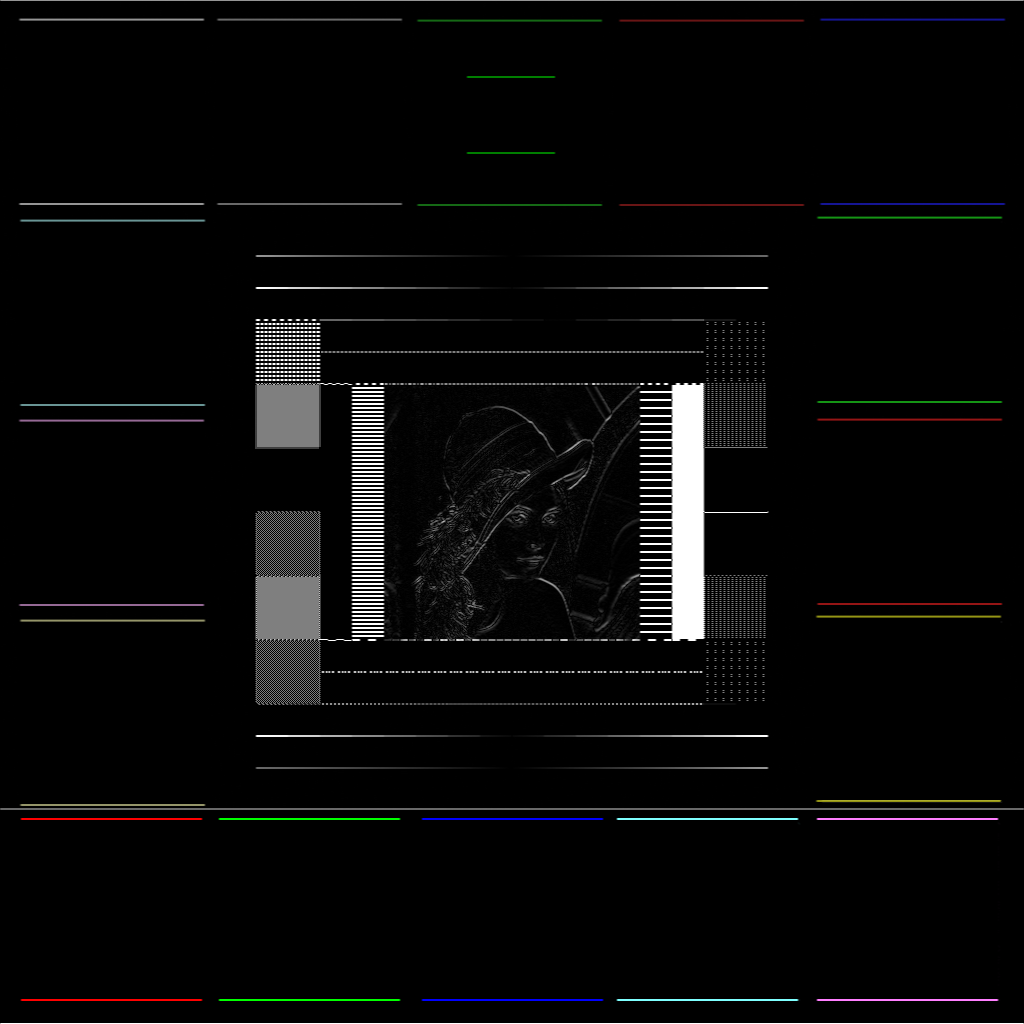

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }

image_file = 'images/lena.tif' # @param {type:"string"}
color_space = 'RGB'  # @param ["RGB", "YIQ"]
kernel_file = 'kernels/sobel_horizontal.txt' # @param {type:"string"}

# Open the image file
image = Image.open(image_file)

with open(kernel_file, 'r') as file:
    # Read the offset from the first line
    offset = tuple(map(int, file.readline().strip().split()))

    # Read the rest of the lines as the kernel
    kernel_lines = file.readlines()
    kernel = np.array([list(map(float, line.strip().split())) for line in kernel_lines])

# Convert the image to a numpy array
image_array = np.asarray(image, dtype=np.uint8)

# Apply linear filters
processor = ImageProcessor()
if color_space == 'RGB':
    image_output = processor.apply_filter_rgb(image_array, BorderDetectionFilter(offset, kernel))
else:
    image_output = processor.apply_filter_yiq(image_array, BorderDetectionFilter(offset, kernel))
display(Image.fromarray(image_output))

### [Step 5.3] ↔️↕️ Run Sobel Filter ↕️↔️

### 🖼️ Image Processing with Sobel Filter

#### Instructions:

1. **Set the image file path:**
   Edit the `image_file` parameter to match the path of your uploaded image file.

2. **Choose the color space:**
   Select either "RGB" or "YIQ" for the `color_space` parameter.

3. **Set the offset (optional):**
   Adjust the `offset` parameters if you want to change brightness

4. **Run the cell:**
   Execute the cell and wait for the image processing to complete.

### Notes:

- The Sobel Filter is an edge detection filter that computes the gradient of image intensity at each pixel.
- It emphasizes edges in both horizontal and vertical directions.
- The filter is applied to all color channels if using RGB, or only to the Y channel if using YIQ.
- The Sobel operator uses two 3x3 kernels to calculate gradients in the x and y directions.
- The resulting image will highlight edges and show the intensity of changes in the image.

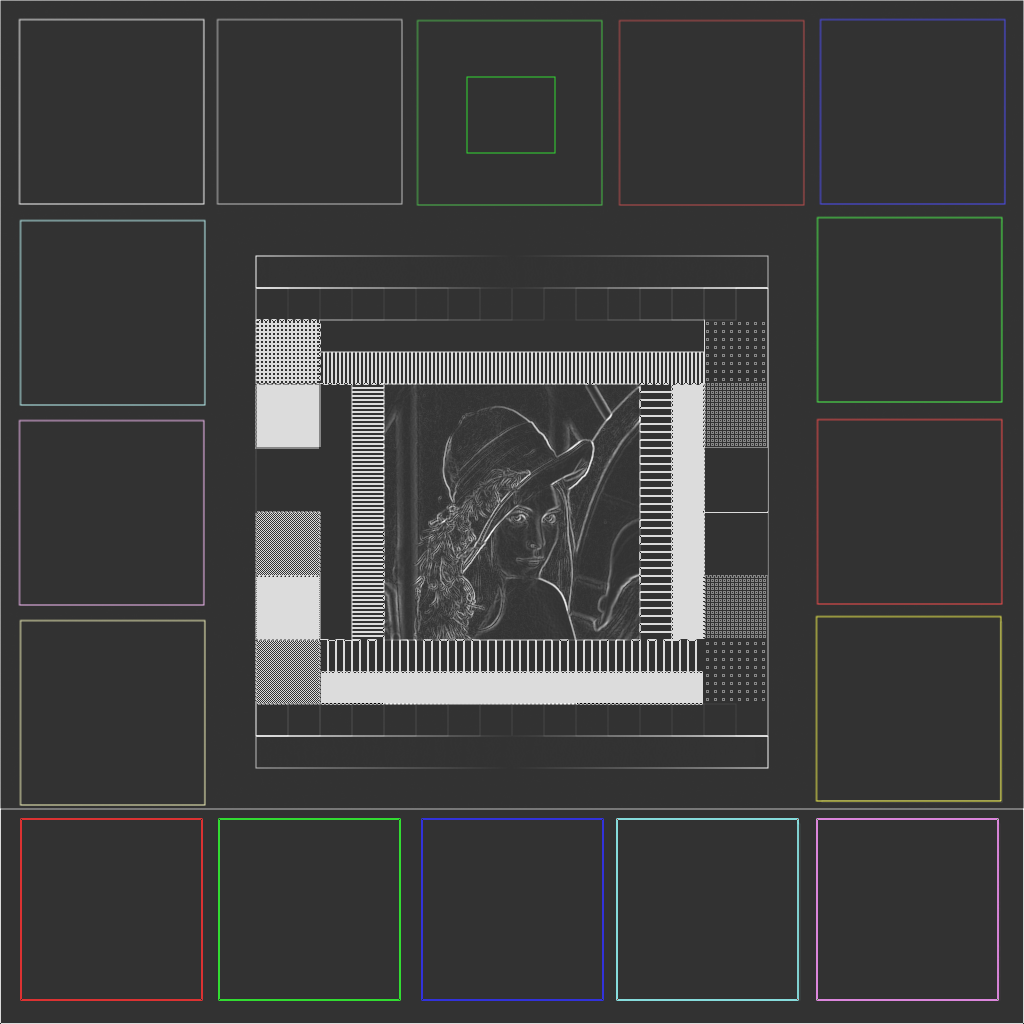

In [ ]:
# @title Click `Show code` in the code cell. { display-mode: "form" }

image_file = 'images/lena.tif' # @param {type:"string"}
color_space = 'RGB'  # @param ["RGB", "YIQ"]
offset = 50 # @param {type:"number"}

# Open the image file
image = Image.open(image_file)

# Convert the image to a numpy array
image_array = np.asarray(image, dtype=np.uint8)

# Apply linear filters
processor = ImageProcessor()
if color_space == 'RGB':
    image_output = processor.apply_filter_rgb(image_array, SobelFilter(offset))
else:
    image_output = processor.apply_filter_yiq(image_array, SobelFilter(offset))
display(Image.fromarray(image_output))